<a href="https://colab.research.google.com/github/Sarvesh1814/Image_Segmentation/blob/main/Lung_Segmenatation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Drive and Kaggle API

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!mkdir -p ~/.kaggle
!cp /content/gdrive/MyDrive/DL_DATA/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Downloading Data

In [3]:
!kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels

100% 9.57G/9.58G [01:56<00:00, 65.6MB/s]
100% 9.58G/9.58G [01:56<00:00, 87.9MB/s]


In [ ]:
!unzip chest-xray-masks-and-labels.zip


# Processing

In [84]:
import numpy as np 
import tensorflow as tf
import pandas as pd
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [85]:
image_path = os.path.join("/content/Lung Segmentation/CXR_png/")
mask_path = os.path.join("/content/Lung Segmentation/","masks/")

In [86]:
images = os.listdir(image_path)
mask = os.listdir(mask_path)

In [87]:
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [88]:
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = [i for i in mask if "mask" in i]

In [89]:
from tqdm import tqdm

def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    if flag == "test":
        for i in tqdm(testing_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]
            
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array,mask_array
    
    if flag == "train":
        for i in tqdm(training_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

In [90]:
def plotMask(X,y):
    sample = []
    
    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left,right))
        sample.append(combined)
        
        
    for i in range(0,6,3):

        plt.figure(figsize=(25,10))
        
        plt.subplot(2,3,1+i)
        plt.imshow(sample[i])
        
        plt.subplot(2,3,2+i)
        plt.imshow(sample[i+1])
        
        
        plt.subplot(2,3,3+i)
        plt.imshow(sample[i+2])
        
        plt.show()

In [91]:
dim = 256
X_train,y_train = getData(dim,flag="train")
X_test, y_test = getData(dim)

100%|██████████| 138/138 [01:00<00:00,  2.27it/s]


training set


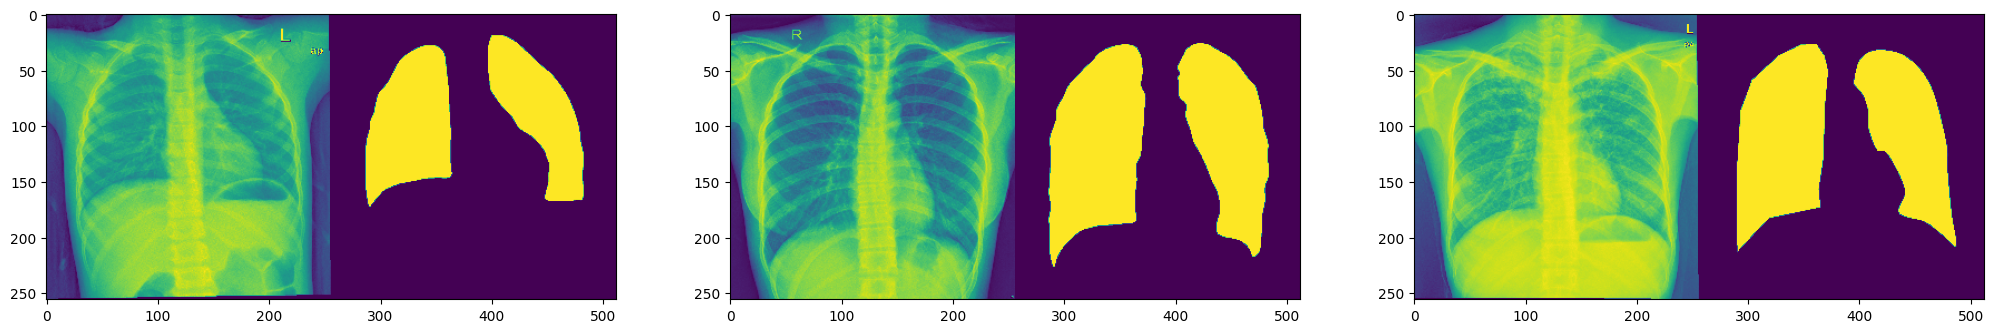

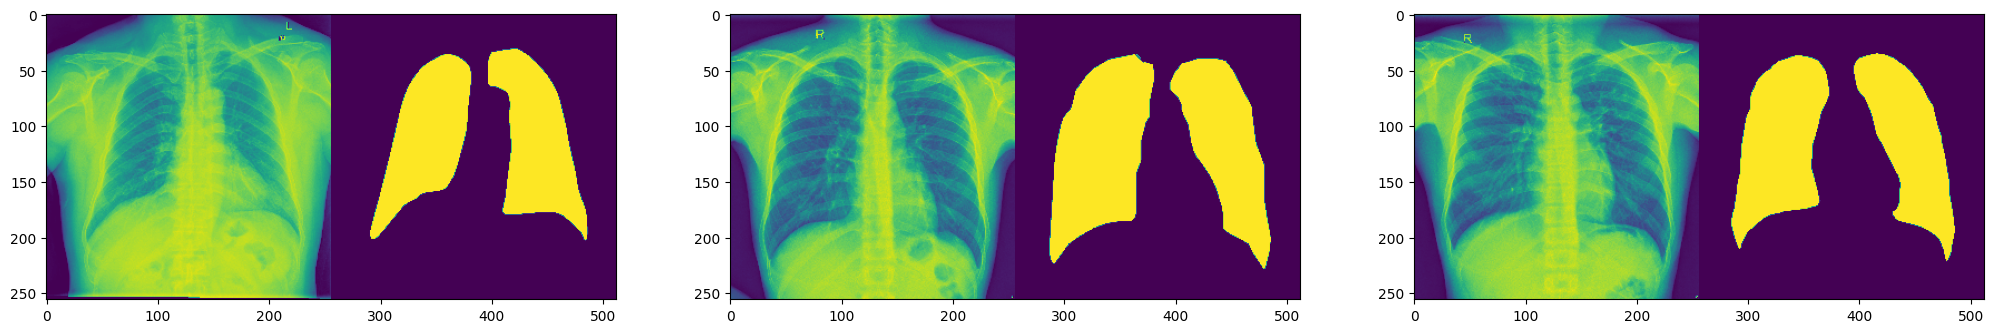

testing set


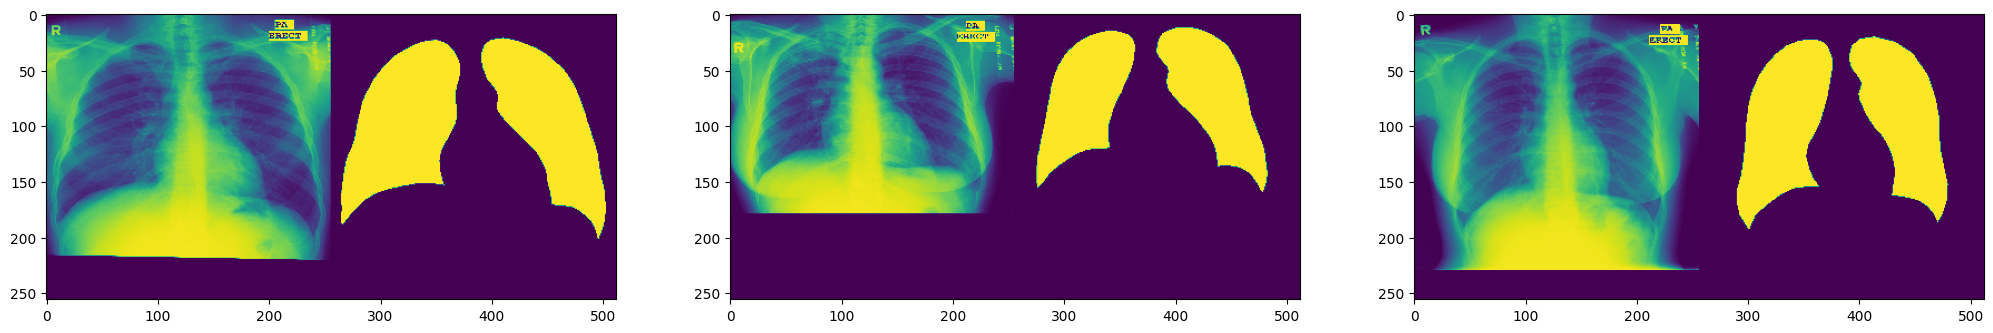

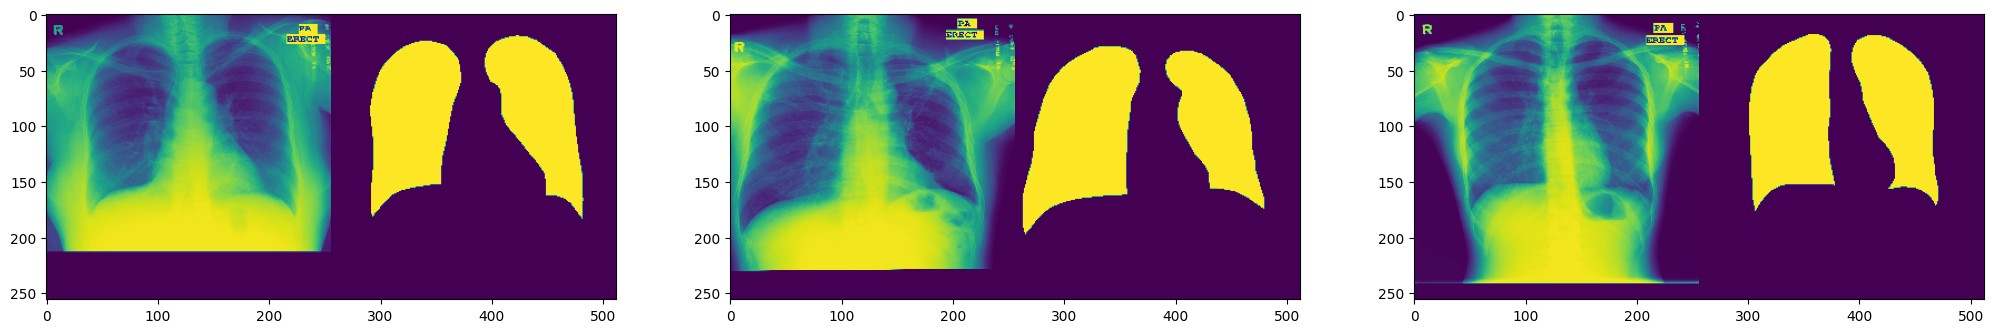

In [92]:
print("training set")
plotMask(X_train,y_train)
print("testing set")
plotMask(X_test,y_test)

In [93]:
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

In [94]:
X_train1 = X_train/255
y_train1 = y_train/255
X_test1 = X_test/255
y_test1 = y_test/255

# Model 

In [95]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.layers.Flatten()(y_true)
    y_pred_f = keras.layers.Flatten()(y_pred)
    y_true_f = tf.cast(y_true_f, tf.float32)
    y_pred_f = tf.cast(y_pred_f, tf.float32)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [96]:
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate,Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [97]:
input_size=(256, 256, 1)
inputs = Input(input_size)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
drop5 = Dropout(0.5)(conv5)

up6 = Conv2D(256, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
merge6 = concatenate([drop4, up6], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = Conv2D(128, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
merge7 = concatenate([conv3, up7], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = Conv2D(64, (2, 2), activation='relu', padding='same')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(64, (3,3), activation='relu', padding='same')(merge8)
conv8 = Conv2D(64, (3,3), activation='relu', padding='same')(conv8)

up9 = Conv2D(32, (2,2), activation='relu', padding='same')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(32, (3,3), activation='relu', padding='same')(merge9)
conv9 = Conv2D(32, (3,3), activation='relu', padding='same')(conv9)
conv9 = Conv2D(2, (3,3), activation='relu', padding='same')(conv9)
conv10 = Conv2D(1, (1,1), activation='sigmoid')(conv9)


In [98]:
model = Model(inputs = inputs, outputs = conv10)
model.compile(optimizer = "adam", loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])


# Model Training

In [99]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train1, y_train1, batch_size=16, epochs=60, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/60
29/29 [==============================] - 23s 471ms/step - loss: -0.3359 - dice_coef: 0.3365 - binary_accuracy: 0.2697 - val_loss: -0.3380 - val_dice_coef: 0.3408 - val_binary_accuracy: 0.2676
Epoch 2/60
29/29 [==============================] - 13s 452ms/step - loss: -0.3372 - dice_coef: 0.3380 - binary_accuracy: 0.2525 - val_loss: -0.3394 - val_dice_coef: 0.3423 - val_binary_accuracy: 0.2530
Epoch 3/60
29/29 [==============================] - 14s 479ms/step - loss: -0.3500 - dice_coef: 0.3518 - binary_accuracy: 0.3387 - val_loss: -0.4087 - val_dice_coef: 0.4111 - val_binary_accuracy: 0.5507
Epoch 4/60
29/29 [==============================] - 14s 478ms/step - loss: -0.3803 - dice_coef: 0.3790 - binary_accuracy: 0.6831 - val_loss: -0.4952 - val_dice_coef: 0.4943 - val_binary_accuracy: 0.8323
Epoch 5/60
29/29 [==============================] - 14s 469ms/step - loss: -0.5400 - dice_coef: 0.5416 - binary_accuracy: 0.8395 - val_loss: -0.5636 - val_dice_coef: 0.5657 - val_binary_ac

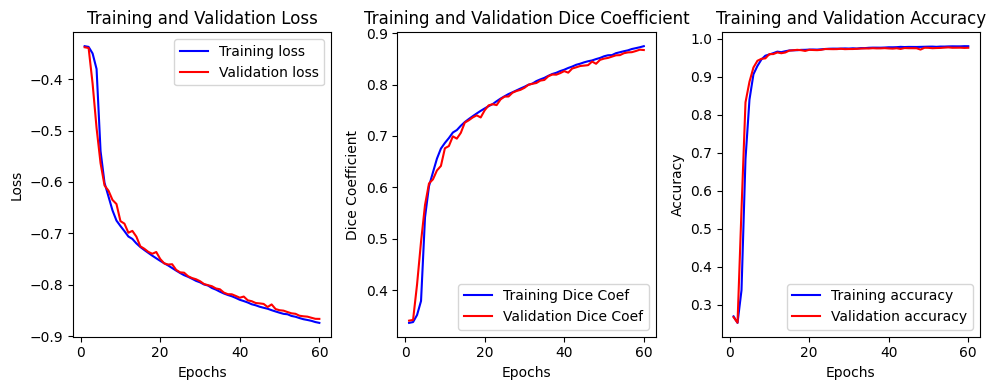

In [105]:
history1 = history.history 
loss = history1['loss']
dice_coef = history1['dice_coef']
accuracy = history1['binary_accuracy']
val_loss = history1['val_loss']
val_dice_coef = history1['val_dice_coef']
val_accuracy = history1['val_binary_accuracy']

# Create plots
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 4))

# Plot training and validation loss
plt.subplot(1, 3, 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation dice coefficient
plt.subplot(1, 3, 2)
plt.plot(epochs, dice_coef, 'b', label='Training Dice Coef')
plt.plot(epochs, val_dice_coef, 'r', label='Validation Dice Coef')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Model Testing

5/5 [==============================] - 1s 187ms/step


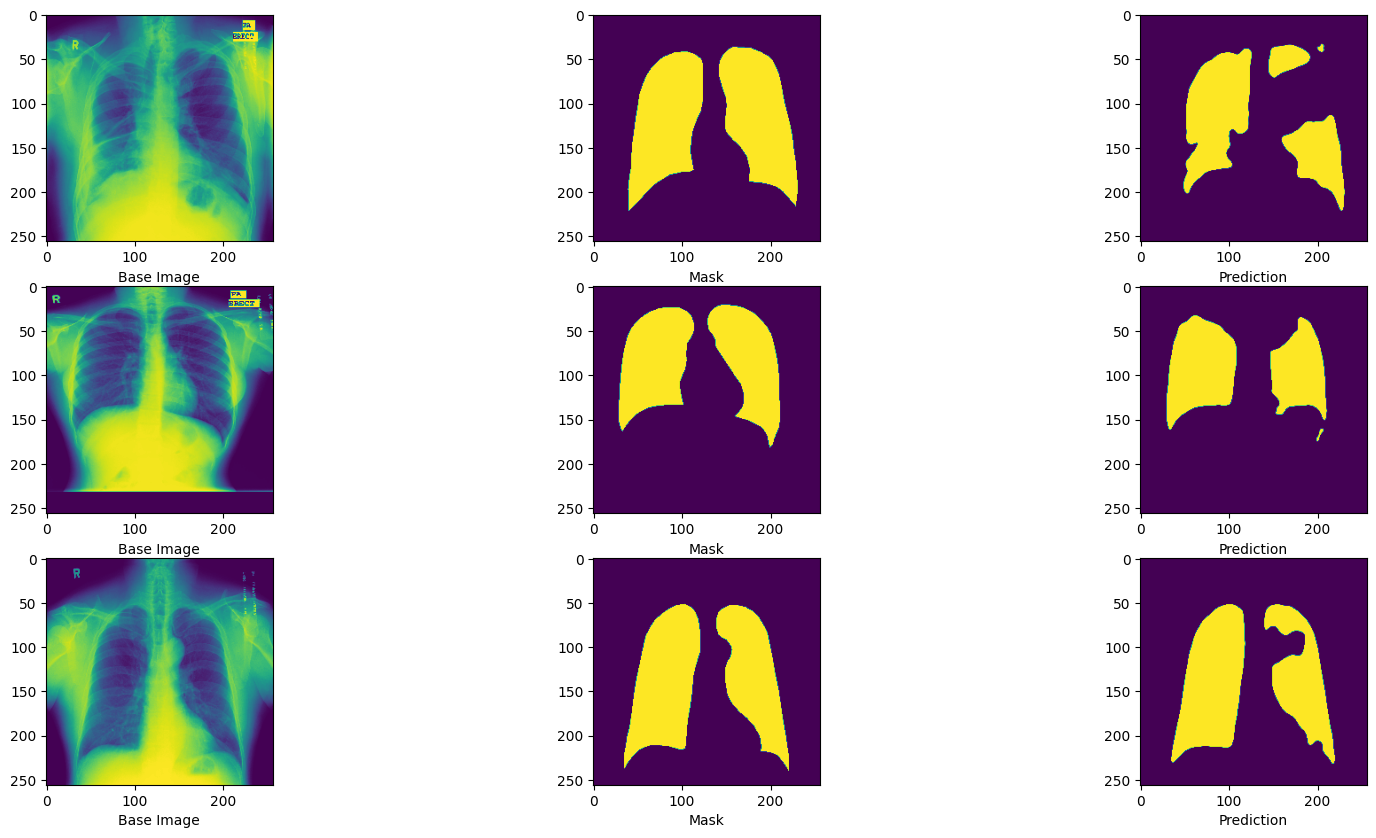

In [100]:
pred_candidates = np.random.randint(1,X_test1.shape[0],10)
preds = model.predict(X_test1)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(X_test1[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(y_test1[pred_candidates[i]]))
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Prediction")